# BIO 265 Final Project - Lily Kalcec, Pre Lavania, and Nicole Haseley

In [1]:
# 1 Import libraries
# standard libraries
import os
import pandas as pd
import numpy as np 
import scipy
from matplotlib import pyplot as plt

# differential expression
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

# dimentionality reduction and clustering
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import umap

from statsmodels.stats.multitest import multipletests

c:\ProgramData\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading in data

In [2]:
# 2 Load in data (final RNAseq readcounts)
RNAseq_data = pd.read_csv("rawcounts-final.csv")
RNAseq_data.drop("ensemble_id_version", axis=1, inplace=True)

In [3]:
RNAseq_data

,CFB2001,CFB2006,CFB2007,CFB2009,CFB2013,CFB2022,CFB2039,CFB2044,CFB2045,CFB2049,...,CFB2146,CFB2149,CFB2152,CFB2159,CFB2160,CFB2163,CFB2166,CFB2169,CFB2171,CFB2186
0,1,4,30,15,4,7,23,19,15,15,...,24,12,14,12,16,7,20,23,20,23
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,741,260,681,1110,640,754,965,1107,906,1105,...,1000,680,533,799,1441,705,1000,1452,1140,1875
3,881,293,782,1013,581,587,884,770,711,1049,...,882,603,512,560,1240,619,763,1504,1011,1421
4,64,30,71,102,72,89,121,124,83,122,...,122,76,40,78,157,85,116,130,117,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60644,14,13,25,38,12,21,23,34,26,36,...,27,20,12,10,28,27,27,45,35,44
60645,2511,1032,2328,2841,3197,1091,3035,1812,1845,3294,...,1773,1722,728,1649,3436,2090,1497,4886,2635,2789
60646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60647,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# 3
##### 03/09/25 - Loadin their DESeq dataset (filtered) #####
# to do: need to look into what Padj is on DESeq. I assume it is some type of multiple hypothesis correction. It is: padj is BH. But, they do not plot this--they plot pvalue. (i looked at their r script)

Their_DESeq_counts_data = pd.read_csv("GSE205161_20220525-geo_deseq_counts.csv.gz", compression='gzip')
Their_DESeq_counts_data.drop("ensemble_id", axis=1, inplace=True)


# PCA: On Raw Readcounts. 

['NTM', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'NTM', 'NTM', 'Control', 'Control', 'NTM', 'NTM', 'NTM', 'Control', 'Control', 'Control', 'NTM', 'Control', 'Control', 'NTM', 'Control', 'NTM', 'Control', 'Control', 'Control', 'NTM', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'NTM', 'Control', 'NTM', 'Control', 'Control', 'Control', 'Control']
            PC1           PC2           PC3            PC4            PC5  \
0 -1.059696e+06  4.951629e+05  5.405992e+05   12049.565419 -345417.188027   
1  3.112132e+06  5.247355e+06  2.861348e+06 -147465.407031   15022.684057   
2  3.288841e+06 -1.823099e+06 -4.269111e+05  -49133.061450   50213.987186   
3  2.446607e+06 -8.347330e+05 -2.706725e+05   41075.182556  -83424.867405   
4 -5.655220e+06 -1.495112e+04 -9.746742e+04   79987.696560 -267626.593152   

            PC6            PC7            PC8            PC9          PC10  
0 -10279.622573 -139122.195251   -2943.248427

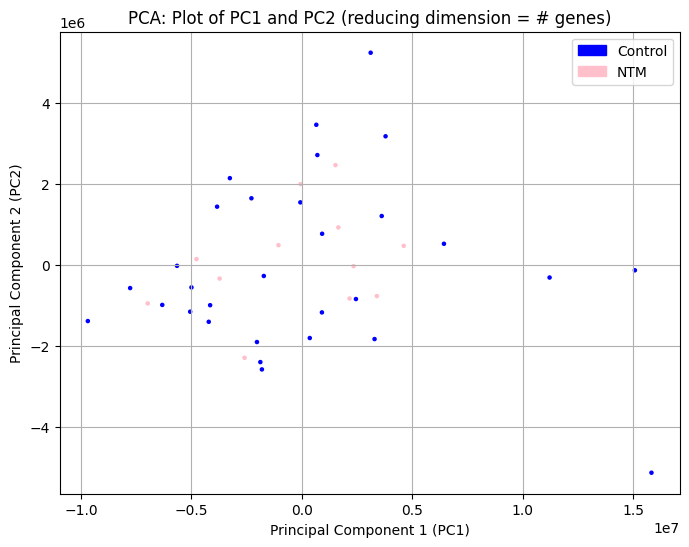

In [ ]:
# 4.1 - PCA: Color by NTM status
##### 03/09/25 - PCA PLOT WHERE THE DIMENSION WE ARE REDUCING IS THE COUNTS PER GENE.
##### Aka, the subset of components we are keeping is a subset of GENES (with the numerical variable being the gene count.)

# Transposing data so that we reduce the desired dimension (genes), and keep our all of our samples (patients).
RNAseq_data_t = RNAseq_data.transpose()

# making useful list of CONTROL or NTM in order that samples come in data frame (for labelling purposes).
# Also adding colors, for labeling purposes.

ordered_list_of_control_vs_ntm_samples = []
ordered_list_of_sample_names = RNAseq_data.columns.tolist()
colors_by_sample_type = []

for i in range(0, len(RNAseq_data_t)):
    if ordered_list_of_sample_names[i] in control_samples:
        ordered_list_of_control_vs_ntm_samples.append("Control")
        colors_by_sample_type.append("Blue")

    elif ordered_list_of_sample_names[i] in ntm_samples:
        ordered_list_of_control_vs_ntm_samples.append("NTM")
        colors_by_sample_type.append("Pink")
print(ordered_list_of_control_vs_ntm_samples)

# PCA
n_PCA_Comps = 10  # Number of PCs to generate 

pca = PCA(n_components=n_PCA_Comps)
principal_components = pca.fit_transform(RNAseq_data_t)

# Create a DataFrame of the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])

# View the first few rows of the PCA results
print(pca_df.head())

# Adding the useful CONTROl or NTM column to our PCA:
pca_df['Sample_Type'] = ordered_list_of_control_vs_ntm_samples
pca_df['Color_for_plot'] = colors_by_sample_type

# Plot the points in PC1 and PC2
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], marker='o', s=5, color = pca_df["Color_for_plot"])

# Add labels and title
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA: Plot of PC1 and PC2 (reducing dimension = # genes)')
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color="blue", label='Control'),
    mpatches.Patch(color="pink", label='NTM') # add as many as needed
]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1))

plt.grid(True)
plt.show()

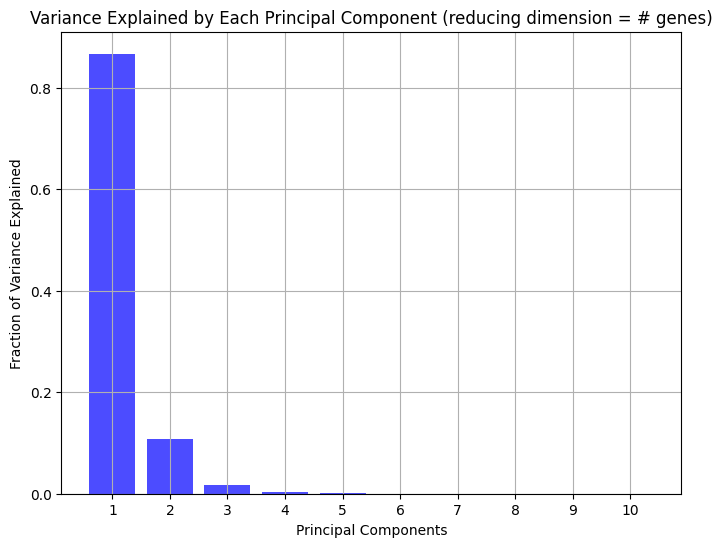

In [ ]:
# 4.2 - Variance explaied as bar graph.
##### 03/09/25 - PCA PLOT WHERE THE DIMENSION WE ARE REDUCING IS THE COUNTS PER GENE. #####

plt.figure(figsize=(8, 6))
plt.bar(range(1, n_PCA_Comps + 1), pca.explained_variance_ratio_, alpha=0.7, color='b')
plt.xlabel('Principal Components')
plt.ylabel('Fraction of Variance Explained')
plt.title('Variance Explained by Each Principal Component (reducing dimension = # genes)')
plt.xticks(range(1, n_PCA_Comps + 1))
plt.grid(True)
plt.show()

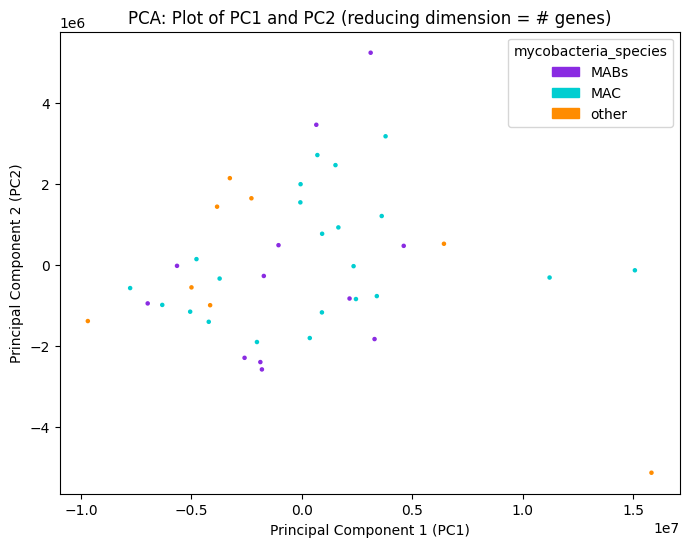

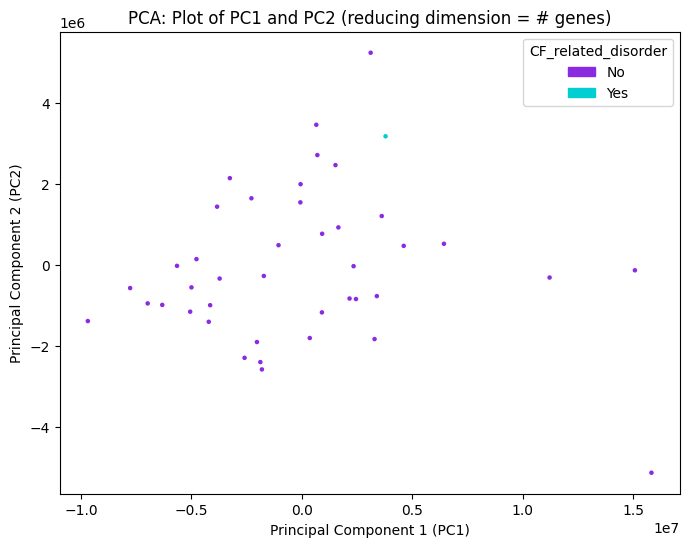

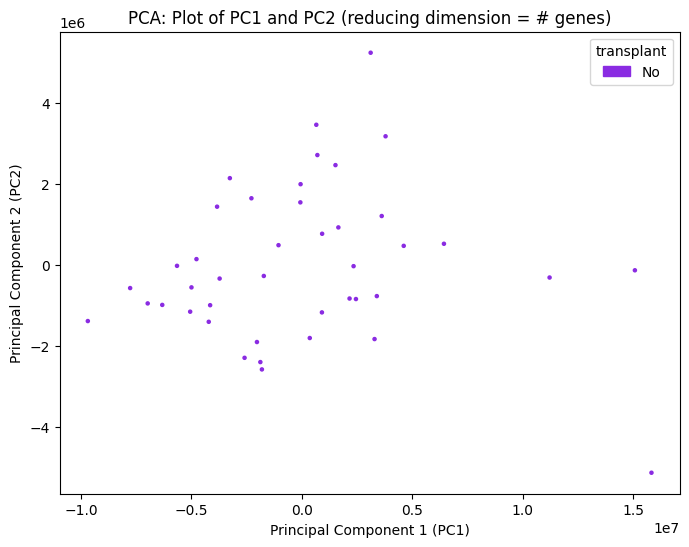

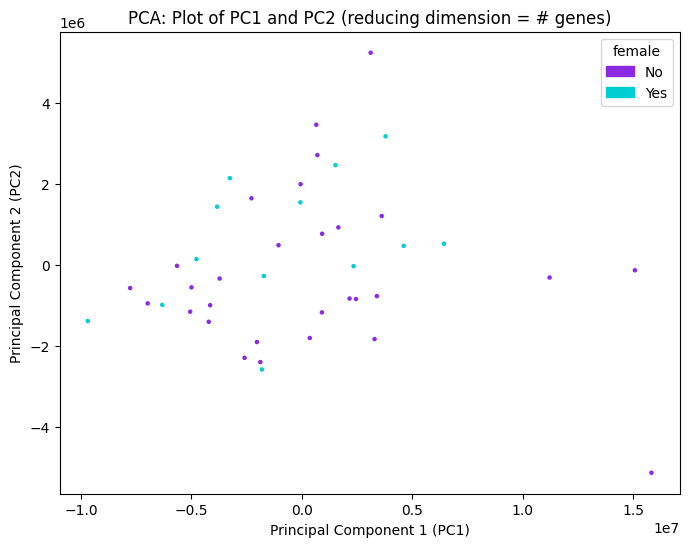

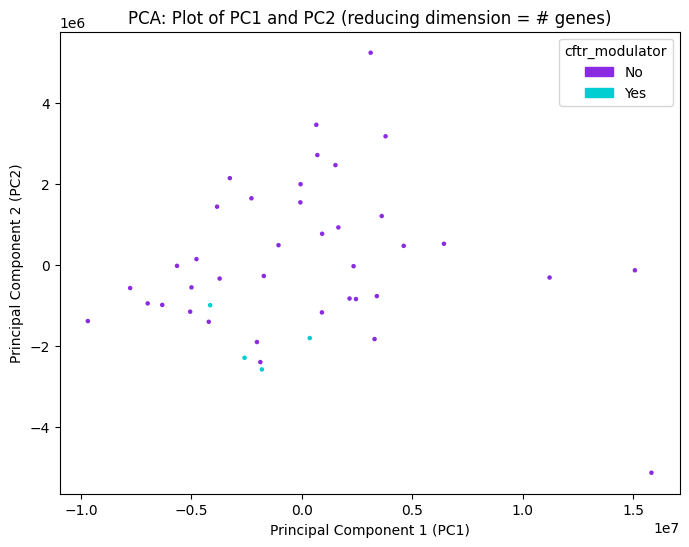

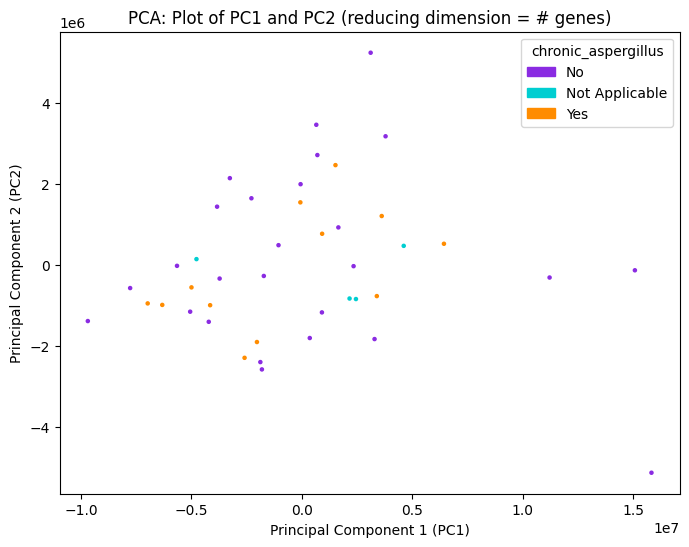

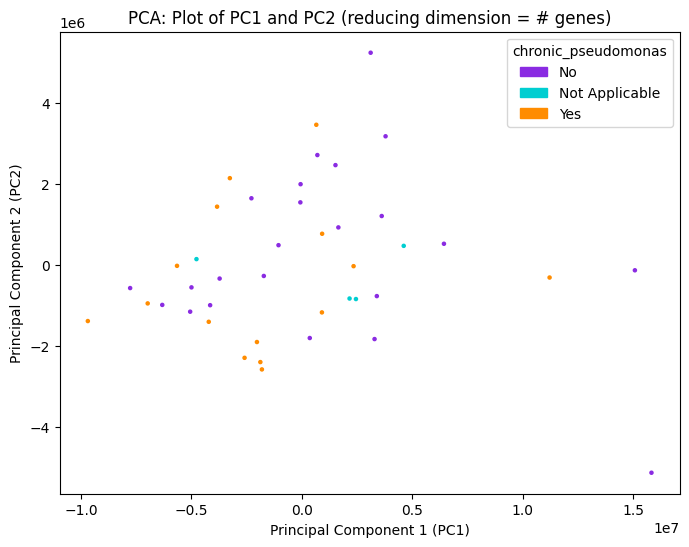

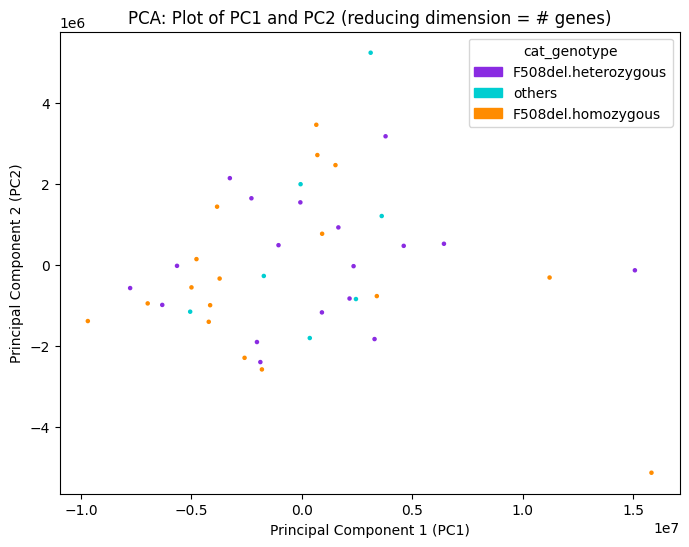

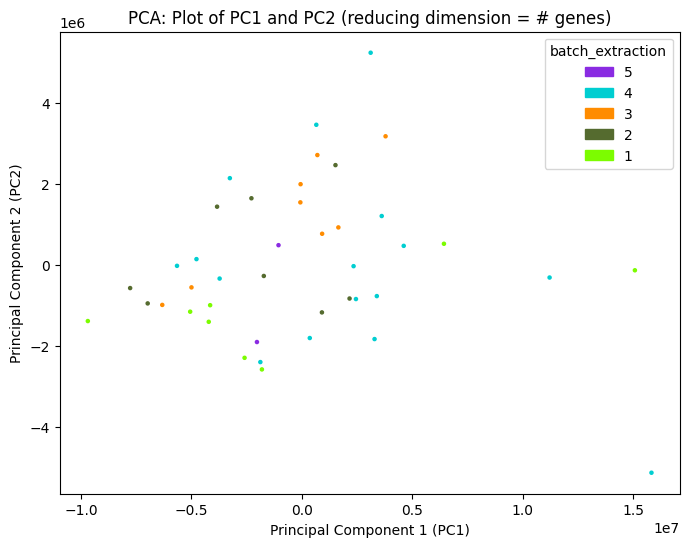

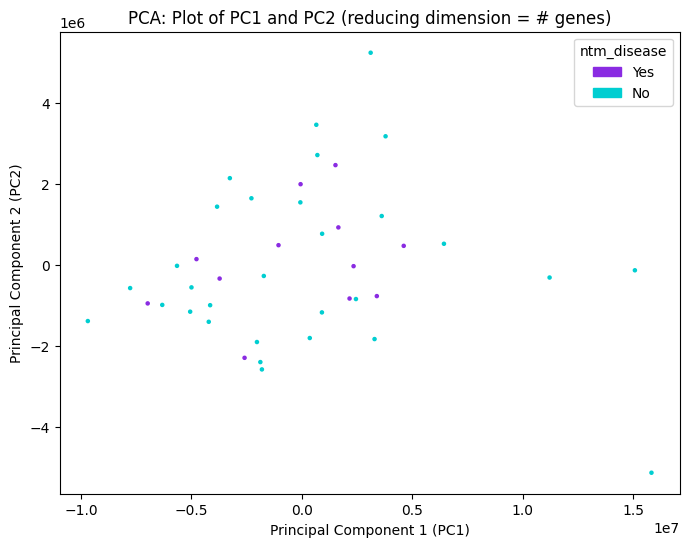

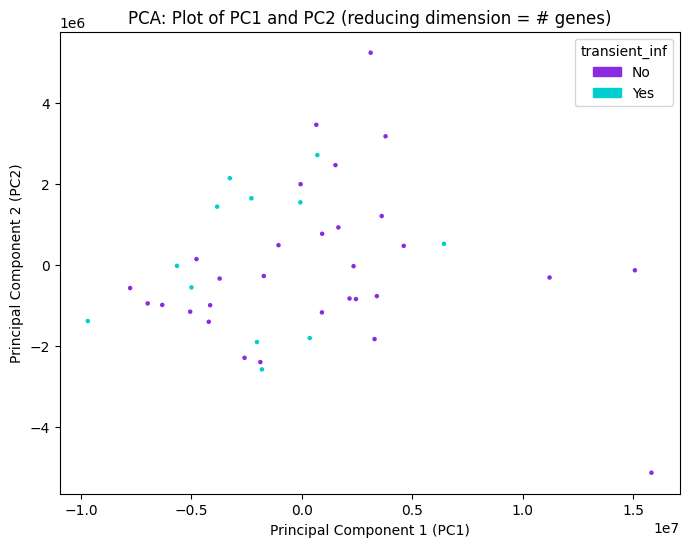

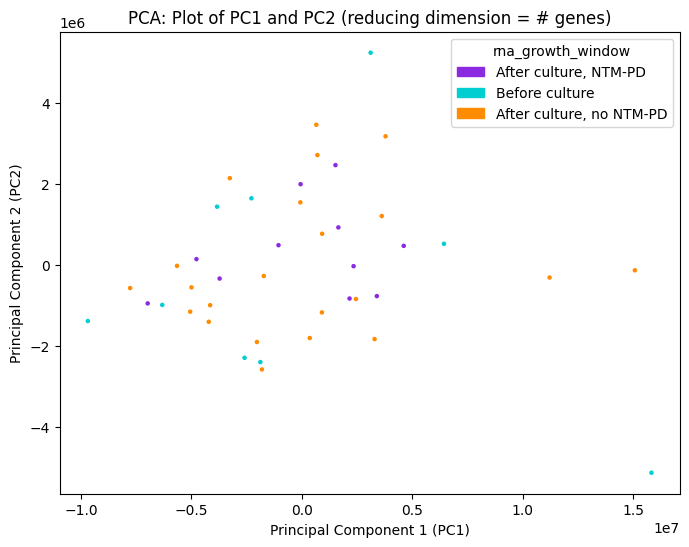

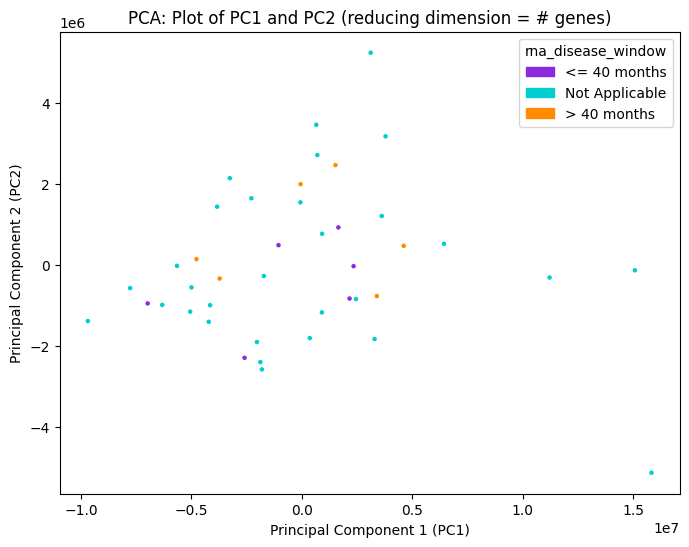

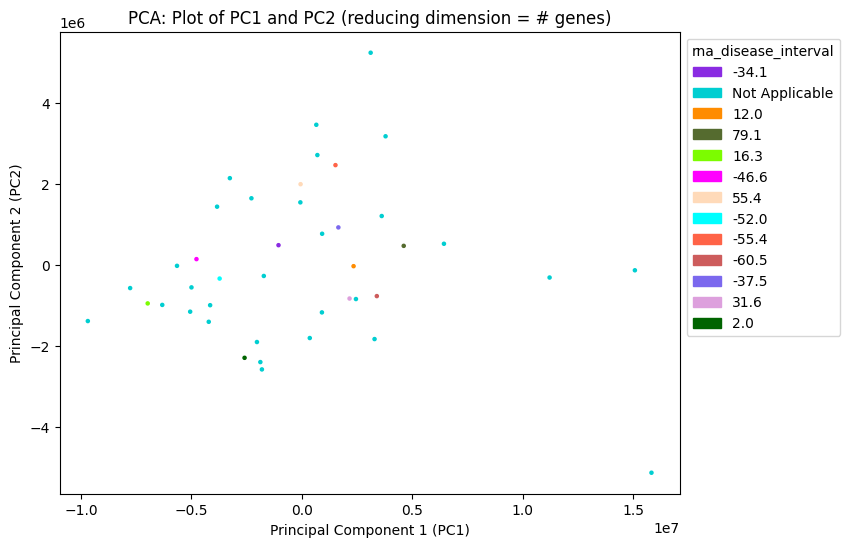

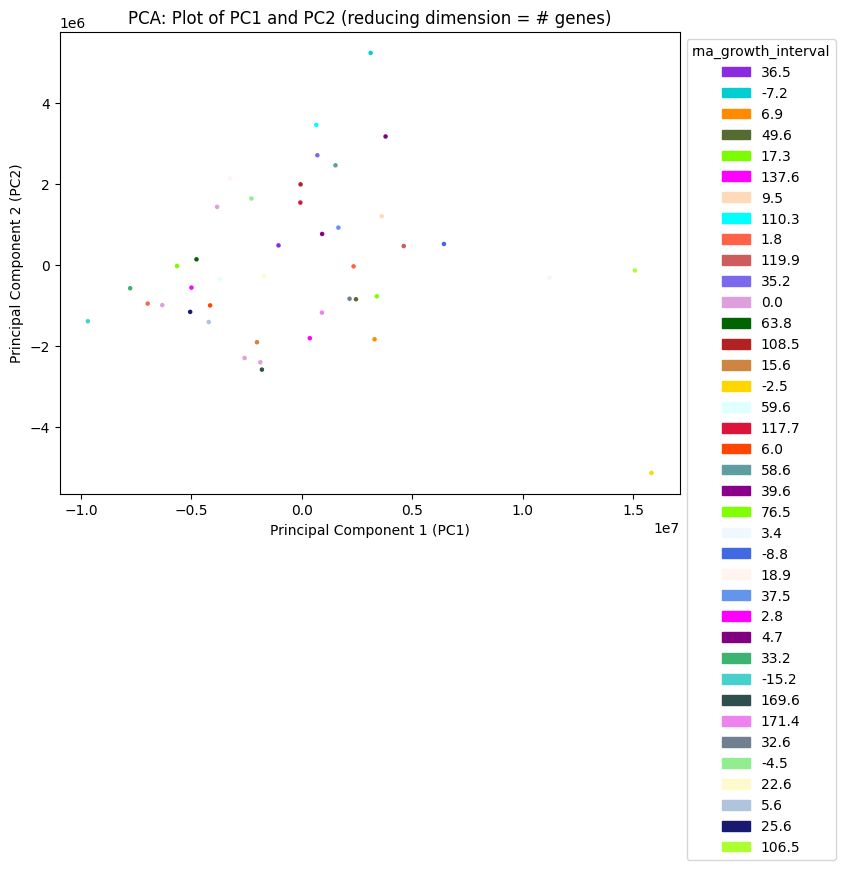

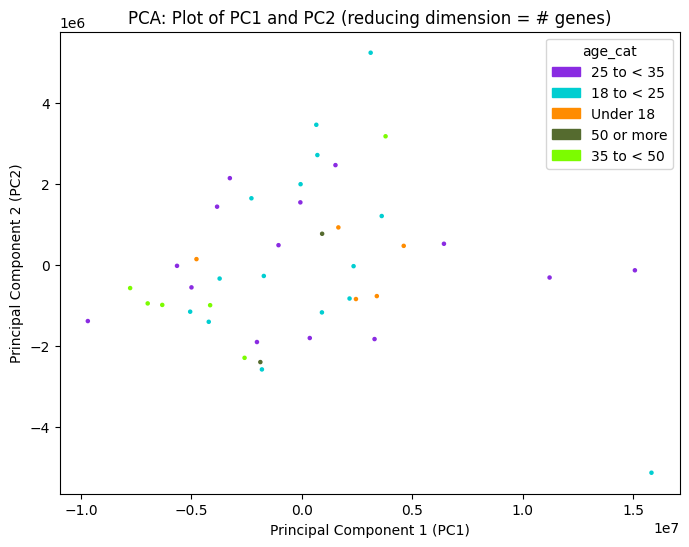

In [ ]:
# 5.1 - Trying to see if we can find a variable that correlates well with the PCA segregation, from the RNAseq metadata
##### 03/10/25

# ----------------seeking variables----------------
# load in metadata from patient RNAseq samples
RNAseq_metadata = pd.read_csv("clinical_rnaseq.csv")
RNAseq_metadata.set_index('CFB_study_id',inplace=True)

# I am most interested in coloring by:
# mycobacteria_species
# female
# cftr_modulator
# chronic_aspergillus
# chronic_pseudomonas
# batch_extraction
# rna_growth_window
# age_cat
# ---------------end seeking variables ---------------------

# -------------PCA--------------------------------
# use transposed data so that we reduce the desired dimension (genes), and keep our all of our samples (patients).
n_PCA_Comps = 10  # Number of PCs to generate 
pca = PCA(n_components=n_PCA_Comps)
principal_components = pca.fit_transform(RNAseq_data_t)
# Create a DataFrame of the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])
# ------------end PCA----------------------------

# -----------------------coloring plot by different variables---------------------------------------
# making useful list of variable factors in order that samples come in data frame (for labelling purposes).
# Also adding colors, for labeling purposes.
ordered_list_of_sample_names = RNAseq_data.columns.tolist()
RNAseq_metadata = RNAseq_metadata.reindex(index=RNAseq_data.columns.tolist())
RNAseq_metadata.fillna('Not Applicable', inplace = True)
list_of_colors = ['blueviolet', 'darkturquoise', 'darkorange', 'darkolivegreen', 'lawngreen', 'magenta', 'peachpuff', 'aqua', "tomato", "indianred", "mediumslateblue", "plum", "darkgreen", "firebrick", "peru", "gold", "lightcyan",
"crimson", "orangered", "cadetblue", "darkmagenta", "chartreuse", "aliceblue", "royalblue",
"seashell", "cornflowerblue", "fuchsia", "purple", "mediumseagreen", "mediumturquoise", "darkslategray", "violet", "slategray",
"lightgreen", "lemonchiffon", "lightsteelblue", "midnightblue", "greenyellow", "deepskyblue", "darkviolet", "yellowgreen",
"lightcoral", "lavenderblush", "darkkhaki", "papayawhip"]

## loopers

#interesting_variables = ['mycobacteria_species', 'female', 'cftr_modulator', 'chronic_aspergillus', 'chronic_pseudomonas', 'batch_extraction', 'rna_growth_window', 'age_cat']
all_variables = RNAseq_metadata.columns.tolist()

for variable in all_variables:

# assigning unique color per factor of given variable
    unique_factors = RNAseq_metadata[variable].unique()
    colors_by_factor = []
    for i in range(0, len(RNAseq_data_t)):
        for j in range(0, len(unique_factors)):
            if RNAseq_metadata[variable][i] == unique_factors[j]:
                colors_by_factor.append(list_of_colors[j])
            else:
                pass

    # turning this into legend handles
    legend_handles = []
    for j in range(0, len(unique_factors)):
        legend_handles.append(mpatches.Patch(color = list_of_colors[j], label = unique_factors[j]))

    # Adding the useful column to our PCA:
    pca_df['Color_for_plot'] = colors_by_factor

    # Plot the points in PC1 and PC2
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], marker='o', s=5, color = pca_df["Color_for_plot"])

    # Add labels and title
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.title('PCA: Plot of PC1 and PC2 (reducing dimension = # genes)')
    legend_handles = legend_handles
    plt.legend(handles=legend_handles,
            bbox_to_anchor=(1,1),
            title = variable)
    plt.show()

# seems like none of them correlate well with PCA component 1!! 


# PCA: On Post-Filtered Readcounts. 

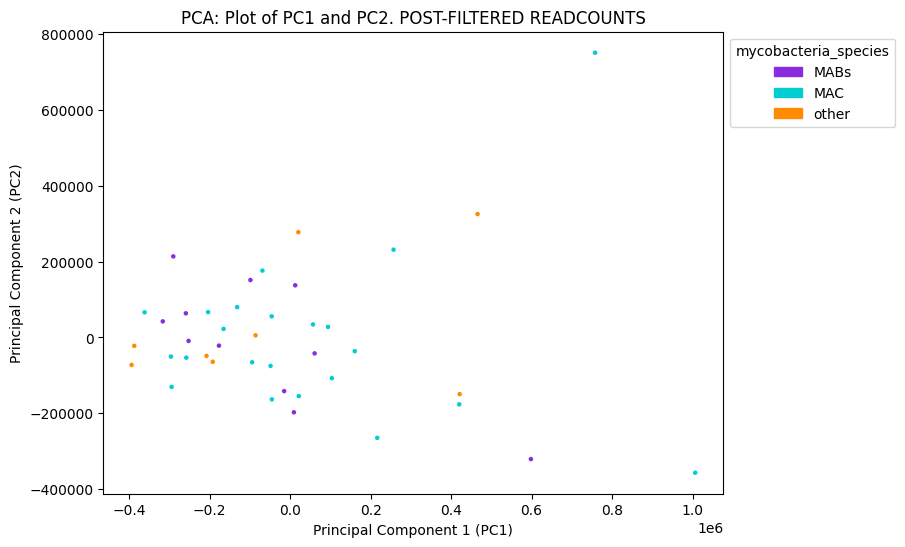

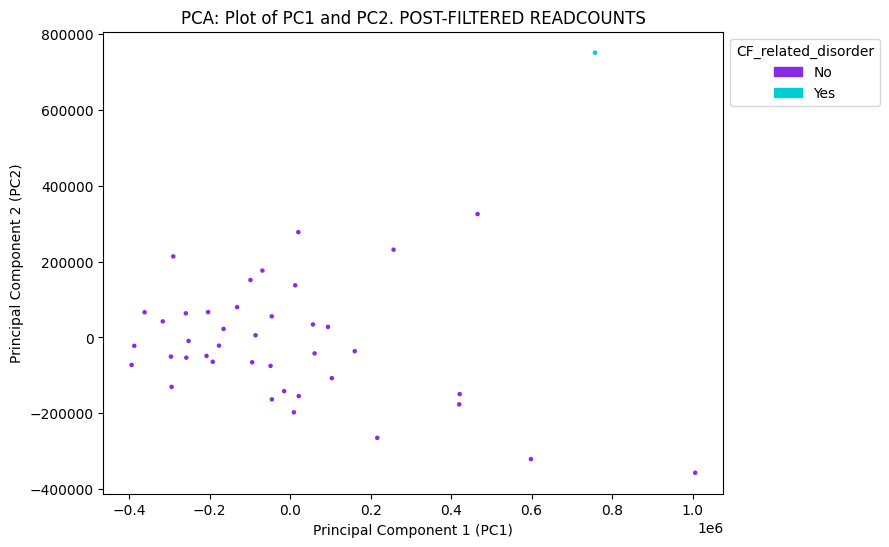

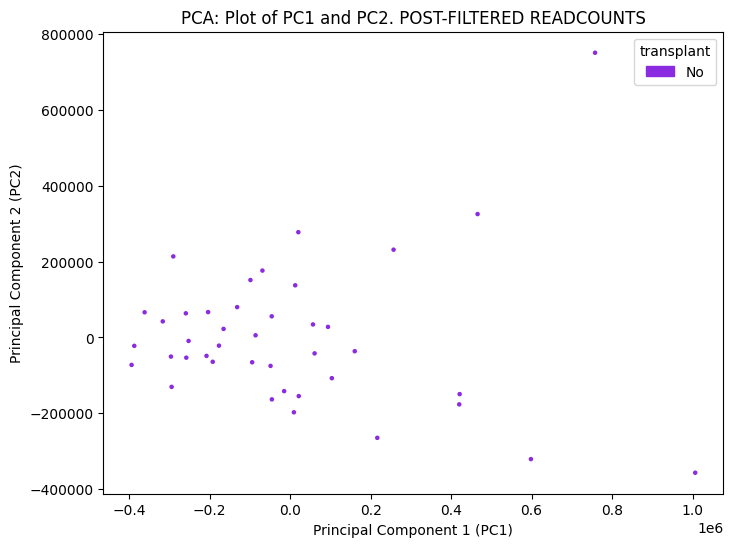

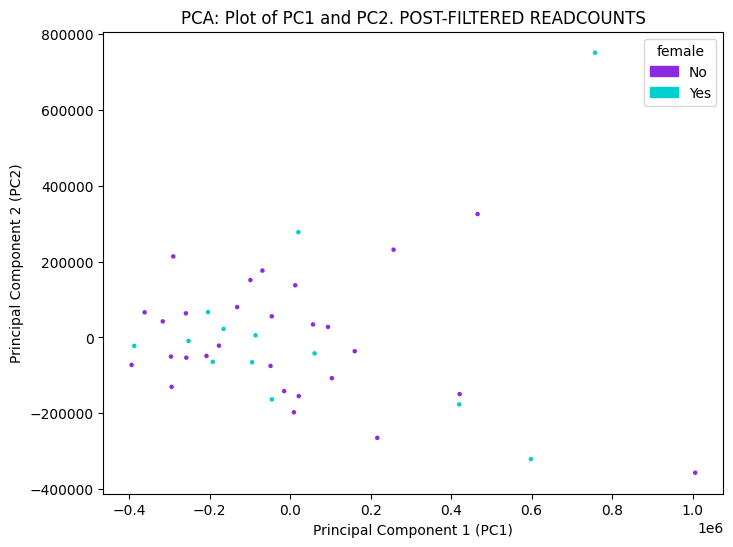

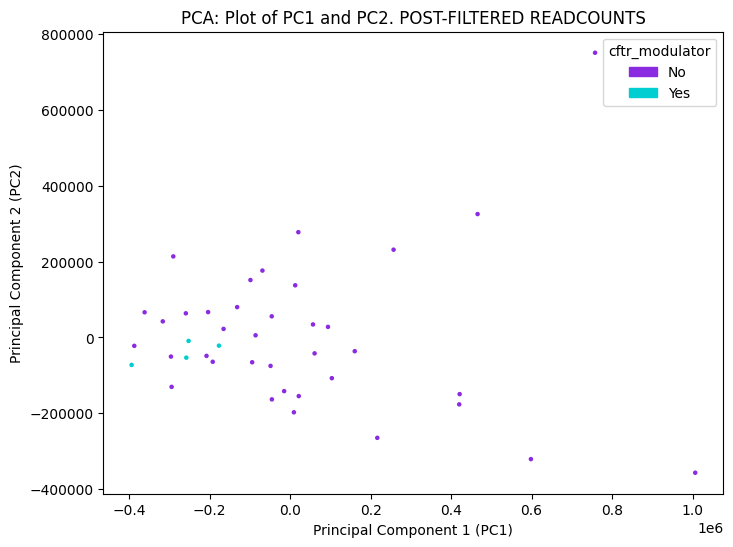

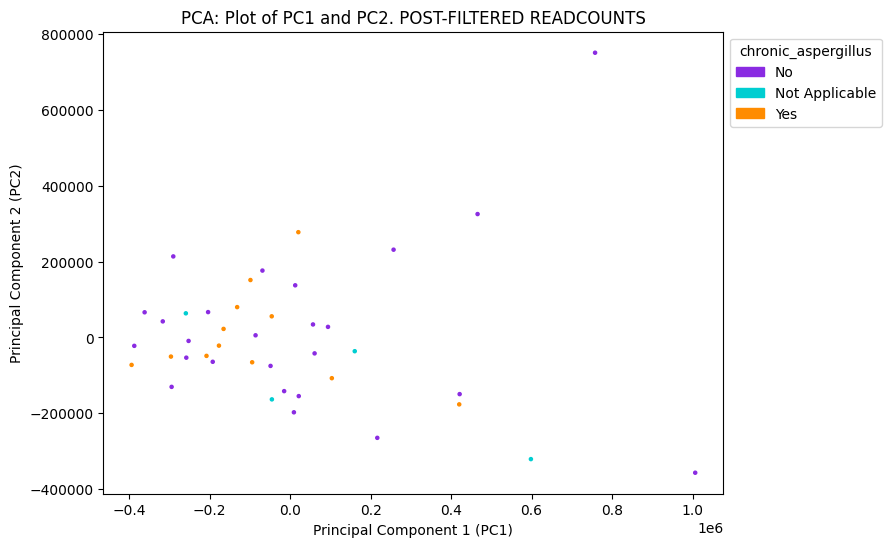

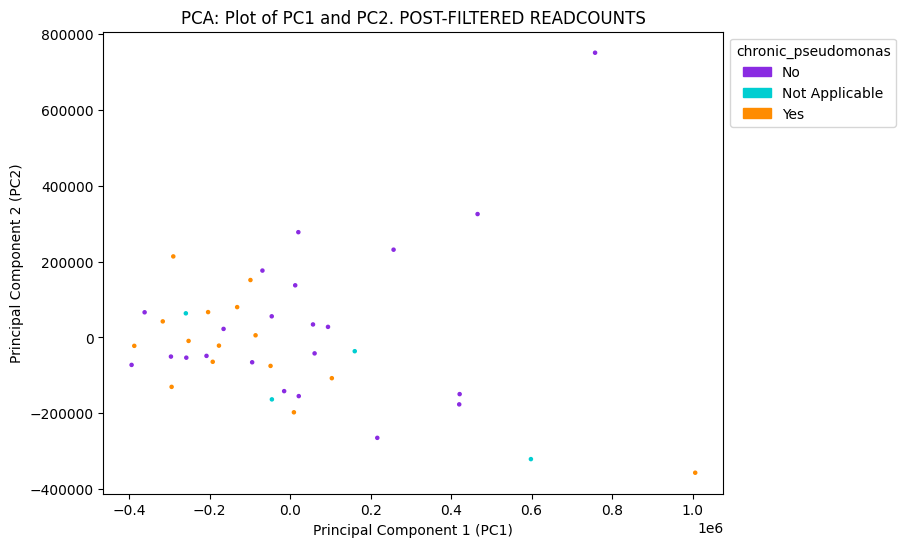

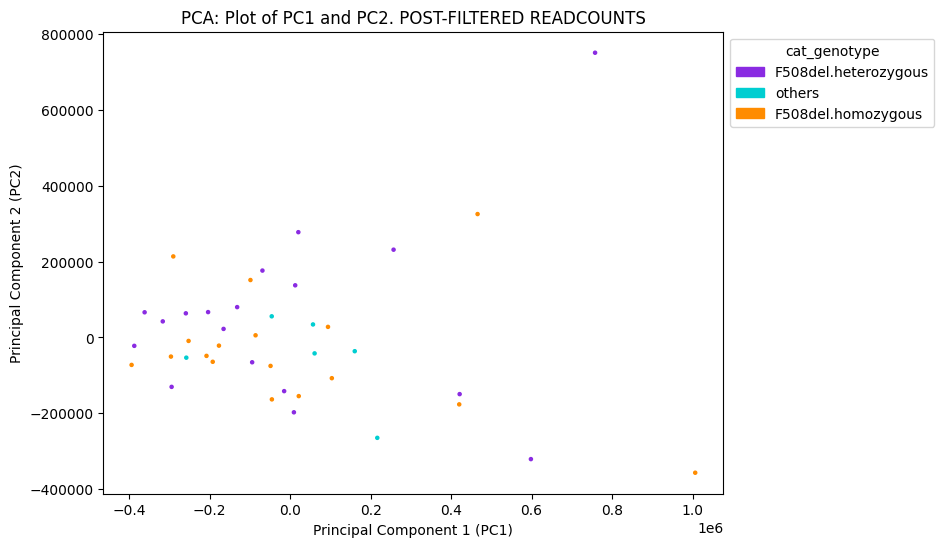

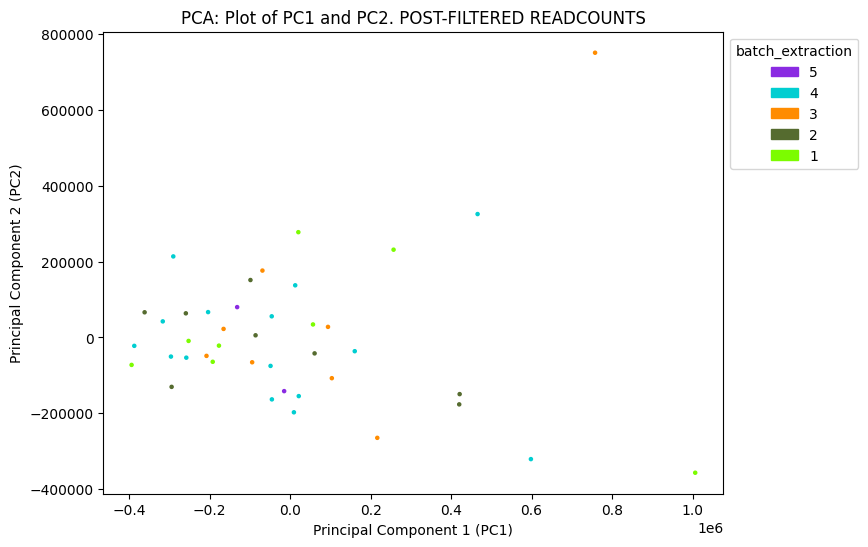

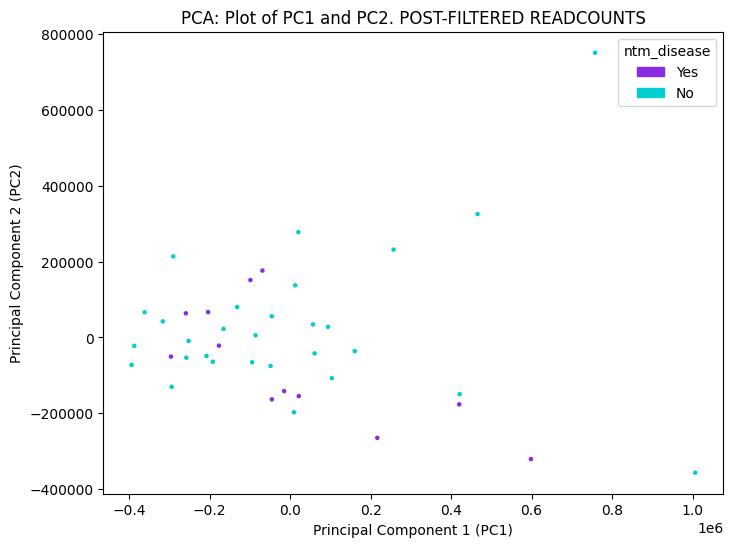

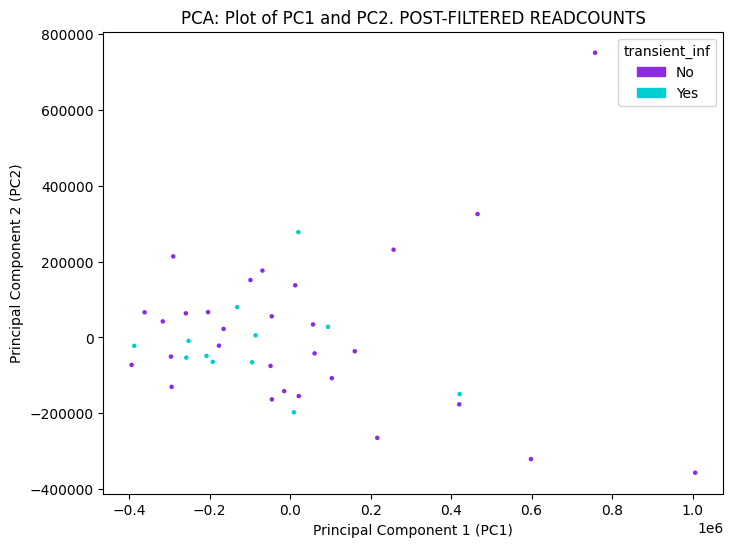

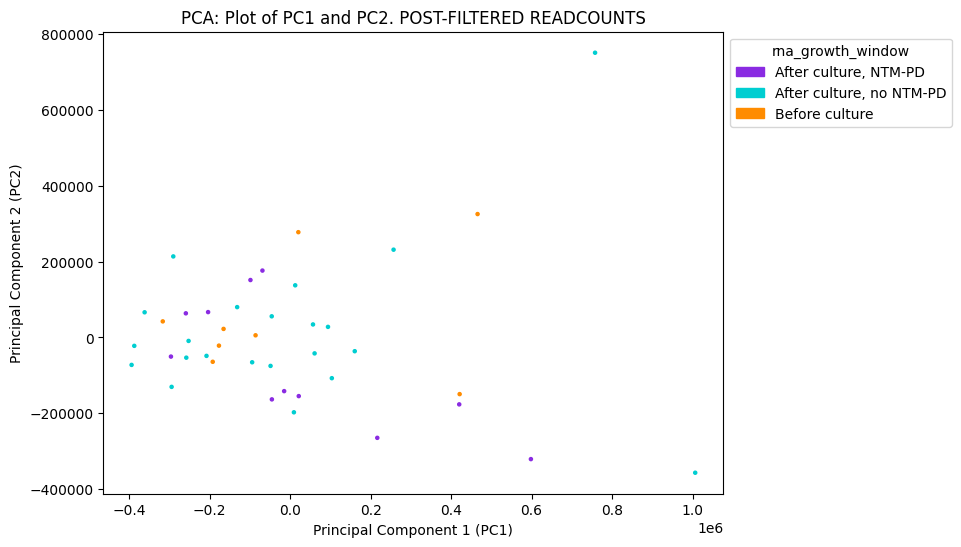

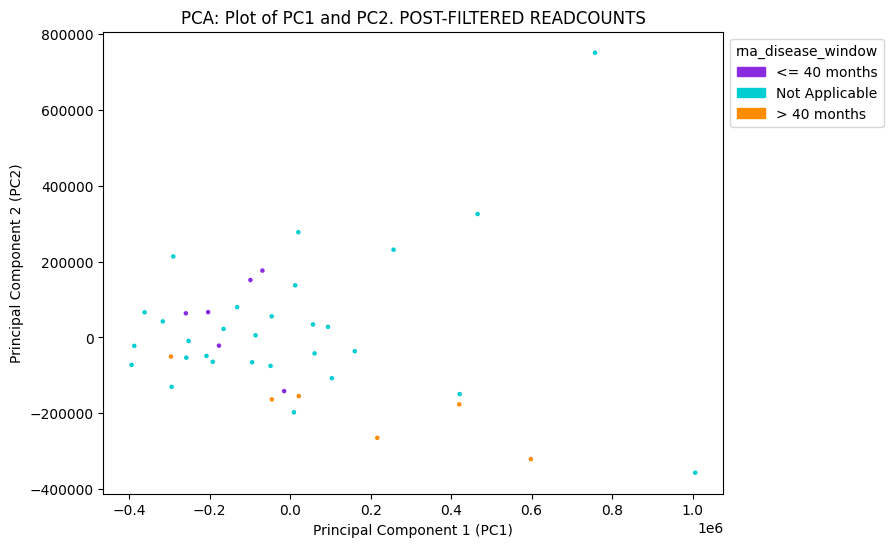

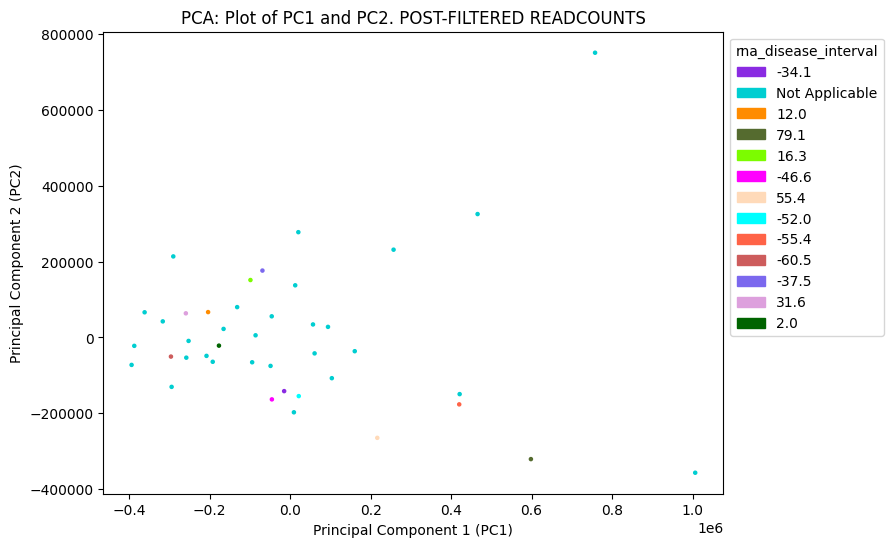

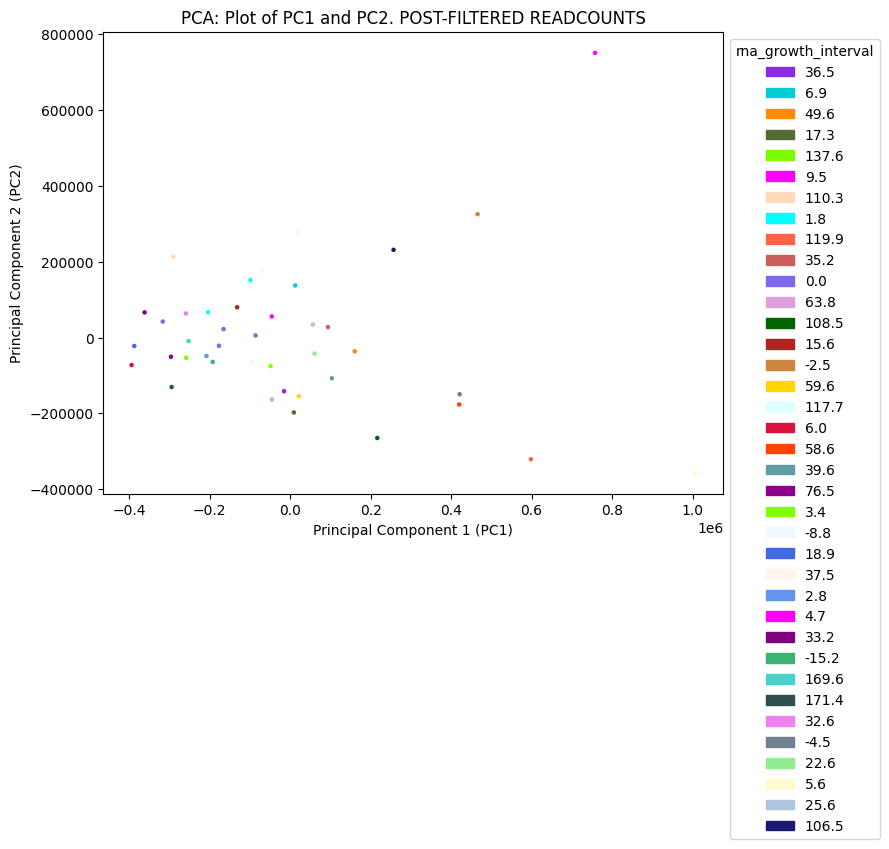

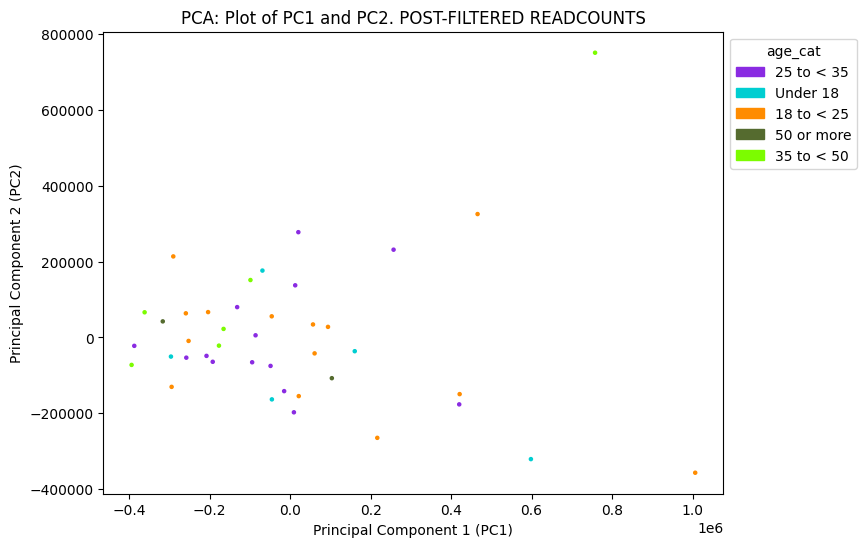

In [ ]:
# 6.1 - Same as above, but... Using their post-filtered dataset
##### 03/18/25

# swapping datasets

RNAseq_data = Their_DESeq_counts_data
RNAseq_data_t = Their_DESeq_counts_data.transpose()


# ----------------seeking variables----------------
# load in metadata from patient RNAseq samples
RNAseq_metadata = pd.read_csv("clinical_rnaseq.csv")
RNAseq_metadata.set_index('CFB_study_id',inplace=True)

# I am most interested in coloring by:
# mycobacteria_species
# female
# cftr_modulator
# chronic_aspergillus
# chronic_pseudomonas
# batch_extraction
# rna_growth_window
# age_cat
# ---------------end seeking variables ---------------------

# -------------PCA--------------------------------
# use transposed data so that we reduce the desired dimension (genes), and keep our all of our samples (patients).
n_PCA_Comps = 10  # Number of PCs to generate 
pca = PCA(n_components=n_PCA_Comps)
principal_components = pca.fit_transform(RNAseq_data_t)
# Create a DataFrame of the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])
# ------------end PCA----------------------------

# -----------------------coloring plot by different variables---------------------------------------
# making useful list of variable factors in order that samples come in data frame (for labelling purposes).
# Also adding colors, for labeling purposes.
ordered_list_of_sample_names = RNAseq_data.columns.tolist()
RNAseq_metadata = RNAseq_metadata.reindex(index=RNAseq_data.columns.tolist())
RNAseq_metadata.fillna('Not Applicable', inplace = True)
list_of_colors = ['blueviolet', 'darkturquoise', 'darkorange', 'darkolivegreen', 'lawngreen', 'magenta', 'peachpuff', 'aqua', "tomato", "indianred", "mediumslateblue", "plum", "darkgreen", "firebrick", "peru", "gold", "lightcyan",
"crimson", "orangered", "cadetblue", "darkmagenta", "chartreuse", "aliceblue", "royalblue",
"seashell", "cornflowerblue", "fuchsia", "purple", "mediumseagreen", "mediumturquoise", "darkslategray", "violet", "slategray",
"lightgreen", "lemonchiffon", "lightsteelblue", "midnightblue", "greenyellow", "deepskyblue", "darkviolet", "yellowgreen",
"lightcoral", "lavenderblush", "darkkhaki", "papayawhip"]

## loopers

#interesting_variables = ['mycobacteria_species', 'female', 'cftr_modulator', 'chronic_aspergillus', 'chronic_pseudomonas', 'batch_extraction', 'rna_growth_window', 'age_cat']
all_variables = RNAseq_metadata.columns.tolist()

for variable in all_variables:

# assigning unique color per factor of given variable
    unique_factors = RNAseq_metadata[variable].unique()
    colors_by_factor = []
    for i in range(0, len(RNAseq_data_t)):
        for j in range(0, len(unique_factors)):
            if RNAseq_metadata[variable][i] == unique_factors[j]:
                colors_by_factor.append(list_of_colors[j])
            else:
                pass

    # turning this into legend handles
    legend_handles = []
    for j in range(0, len(unique_factors)):
        legend_handles.append(mpatches.Patch(color = list_of_colors[j], label = unique_factors[j]))

    # Adding the useful column to our PCA:
    pca_df['Color_for_plot'] = colors_by_factor

    # Plot the points in PC1 and PC2
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], marker='o', s=5, color = pca_df["Color_for_plot"])

    # Add labels and title
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.title('PCA: Plot of PC1 and PC2. POST-FILTERED READCOUNTS')
    legend_handles = legend_handles
    plt.legend(handles=legend_handles,
            bbox_to_anchor=(1,1),
            title = variable)
    plt.show()

# seems like none of them correlate well with PCA component 1!! 


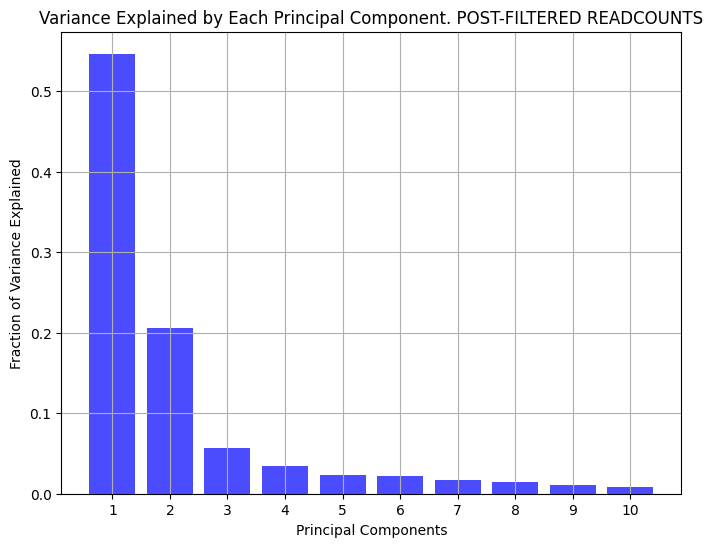

In [ ]:
# 6.2
##### 03/18/25 - PERCENTAGES OF VARIABILITY: PCA PLOT WHERE THE DIMENSION WE ARE REDUCING IS THE COUNTS PER GENE. #####

plt.figure(figsize=(8, 6))
plt.bar(range(1, n_PCA_Comps + 1), pca.explained_variance_ratio_, alpha=0.7, color='b')
plt.xlabel('Principal Components')
plt.ylabel('Fraction of Variance Explained')
plt.title('Variance Explained by Each Principal Component. POST-FILTERED READCOUNTS')
plt.xticks(range(1, n_PCA_Comps + 1))
plt.grid(True)
plt.show()
